In [3]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.plot import show
from pathlib import Path


In [4]:

DATA = Path("images/")

files = {
    '2018': {
        'red': DATA / '2018-09-12-00:00_2018-09-12-23:59_Sentinel-2_L2A_B04_(Raw).tiff',
        'nir': DATA / '2018-09-12-00:00_2018-09-12-23:59_Sentinel-2_L2A_B08_(Raw).tiff'
    },
    '2020': {
        'red': DATA / '2020-09-11-00:00_2020-09-11-23:59_Sentinel-2_L2A_B04_(Raw).tiff',
        'nir': DATA / '2020-09-11-00:00_2020-09-11-23:59_Sentinel-2_L2A_B08_(Raw).tiff'
    },
    '2023': {
        'red': DATA / '2023-09-11-00:00_2023-09-11-23:59_Sentinel-2_L2A_B04_(Raw).tiff',
        'nir': DATA / '2023-09-11-00:00_2023-09-11-23:59_Sentinel-2_L2A_B08_(Raw).tiff'
    }
}


In [5]:
def compute_ndvi(nir, red):
    nir = nir.astype('float32')
    red = red.astype('float32')
    ndvi = (nir - red) / (nir + red + 1e-6)
    return ndvi


In [6]:
ndvi_data = {}

for year, paths in files.items():
    with rasterio.open(paths['nir']) as nir_src, rasterio.open(paths['red']) as red_src:
        nir = nir_src.read(1)
        red = red_src.read(1)
        ndvi = compute_ndvi(nir, red)
        ndvi_data[year] = {
            'ndvi': ndvi,
            'profile': nir_src.profile
        }

    print(f"Loaded and computed NDVI for {year}")


Loaded and computed NDVI for 2018
Loaded and computed NDVI for 2020
Loaded and computed NDVI for 2023


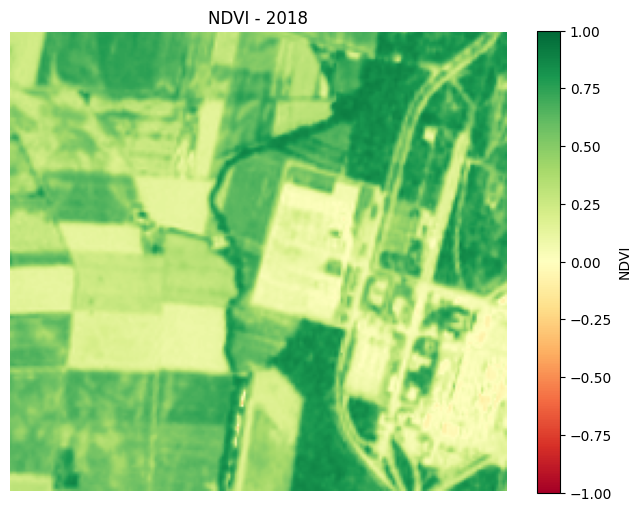

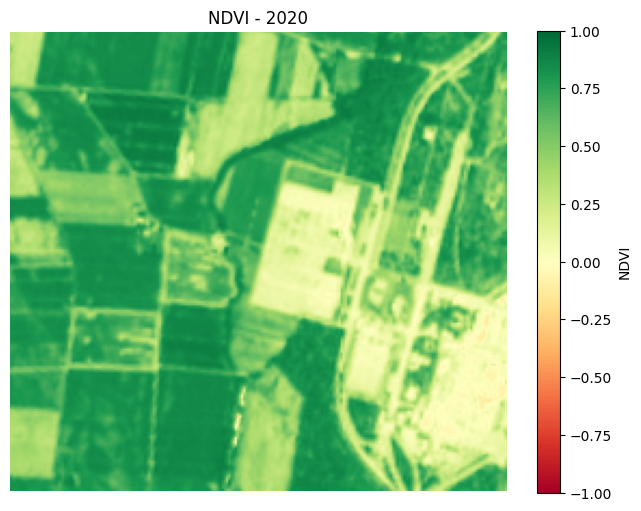

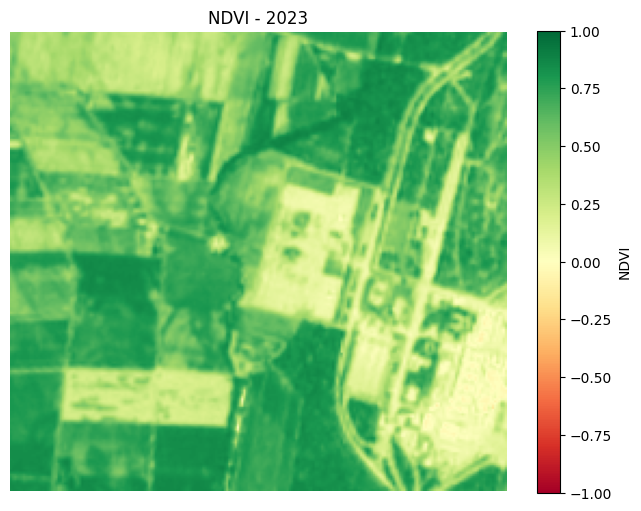

In [7]:
def plot_ndvi(ndvi, title):
    plt.figure(figsize=(8, 6))
    plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)
    plt.colorbar(label='NDVI')
    plt.title(title)
    plt.axis('off')
    plt.show()

for year in ndvi_data:
    plot_ndvi(ndvi_data[year]['ndvi'], f"NDVI - {year}")


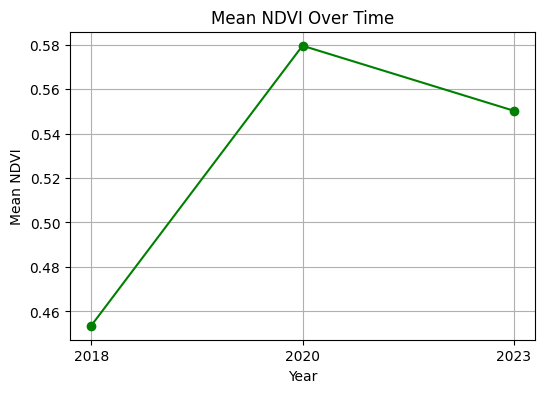

In [8]:
years = []
means = []

for year, data in ndvi_data.items():
    mean_val = np.nanmean(data['ndvi'])
    years.append(year)
    means.append(mean_val)

plt.figure(figsize=(6, 4))
plt.plot(years, means, marker='o', linestyle='-', color='green')
plt.title('Mean NDVI Over Time')
plt.xlabel('Year')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.show()


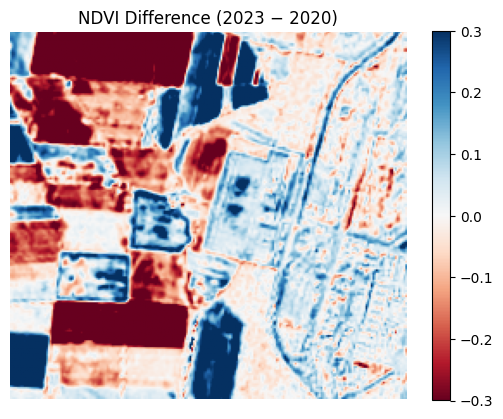

In [10]:
diff = ndvi_data['2023']['ndvi'] - ndvi_data['2020']['ndvi']
plt.imshow(diff, cmap='RdBu', vmin=-0.3, vmax=0.3)
plt.title("NDVI Difference (2023 − 2020)")
plt.colorbar()
plt.axis('off')
plt.show()

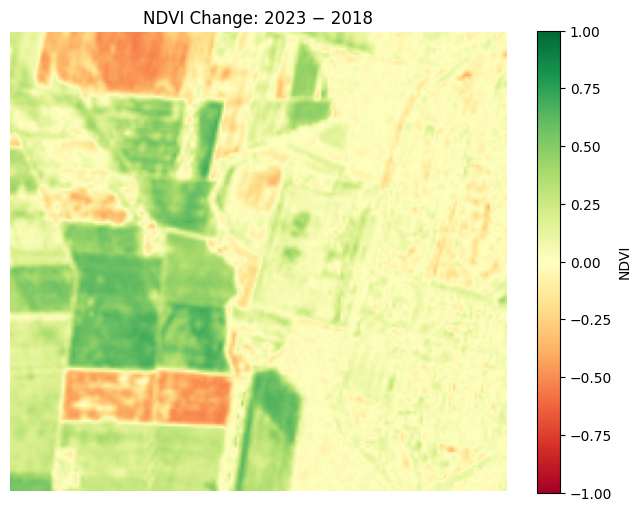

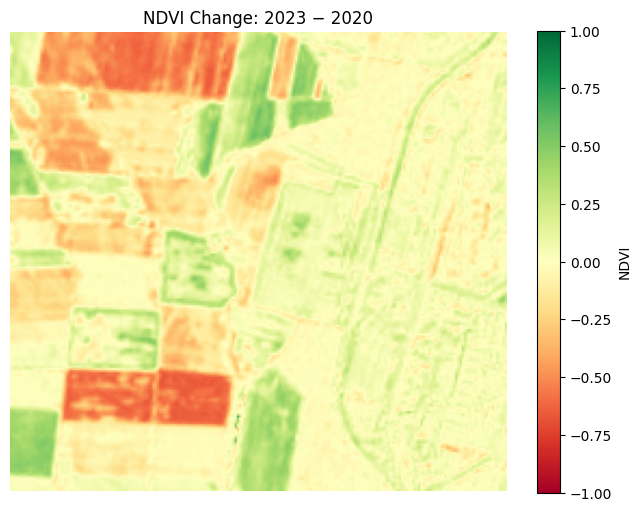

In [11]:
diff_2023_2018 = ndvi_data['2023']['ndvi'] - ndvi_data['2018']['ndvi']
diff_2023_2020 = ndvi_data['2023']['ndvi'] - ndvi_data['2020']['ndvi']
    
plot_ndvi(diff_2023_2018, "NDVI Change: 2023 − 2018")
plot_ndvi(diff_2023_2020, "NDVI Change: 2023 − 2020")


In [63]:
def save_geotiff(filename, array, profile):
    profile.update(dtype=rasterio.float32, count=1)
    with rasterio.open(filename, 'w', **profile) as dst:
        dst.write(array.astype(rasterio.float32), 1)

save_geotiff("NDVI_2018.tif", ndvi_data['2018']['ndvi'], ndvi_data['2018']['profile'])
save_geotiff("NDVI_2020.tif", ndvi_data['2020']['ndvi'], ndvi_data['2020']['profile'])
save_geotiff("NDVI_2023.tif", ndvi_data['2023']['ndvi'], ndvi_data['2023']['profile'])

save_geotiff("NDVI_DIFF_2023_2018.tif", diff_2023_2018, ndvi_data['2023']['profile'])
